# System Identification - FOPDT Model

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skopt
import lpfgopt
from skopt.space import Real, Integer
from problems.optprob.problems import ( 
    solve_problem_with_optimizer,
    solve_problem_with_optimizer_n_repeats
)
from problems.optprob.plot_utils import (
    function_evaluations_plot, best_guesses_plot, best_guesses_plot_n_repeats
)
from problems.sys_id_fopdt.sys_id_fopdt import (
    make_simulate_function,
    rms_prediction_error,
    SysIdFOPDT, 
    calculate_reasonable_bounds,
    SysIdFOPDTRealDelay
)

lpfgopt.__version__

'1.0.1'

## Load Input-Output Dataset

In [26]:
data_dir = 'problems/sys_id_fopdt/data'
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)
os.listdir(data_dir)

['io_data_fopdt.csv']

In [27]:
filename = 'io_data_fopdt.csv'
input_output_data = pd.read_csv(os.path.join(data_dir, filename))
input_output_data

,Output,Time,Input1,Input2
0,529.426479,5011.92,3.848257,950.433
1,529.406915,5027.04,3.848752,951.558
2,529.359303,5042.16,3.844561,948.592
3,529.324639,5057.28,3.855842,947.967
4,529.252920,5072.04,3.850157,951.153
...,...,...,...,...
876,482.210406,18171.00,6.373414,933.481
877,480.748231,18186.12,6.370664,933.328
878,478.999084,18201.24,6.370291,936.604
879,477.031966,18216.00,6.378411,935.107


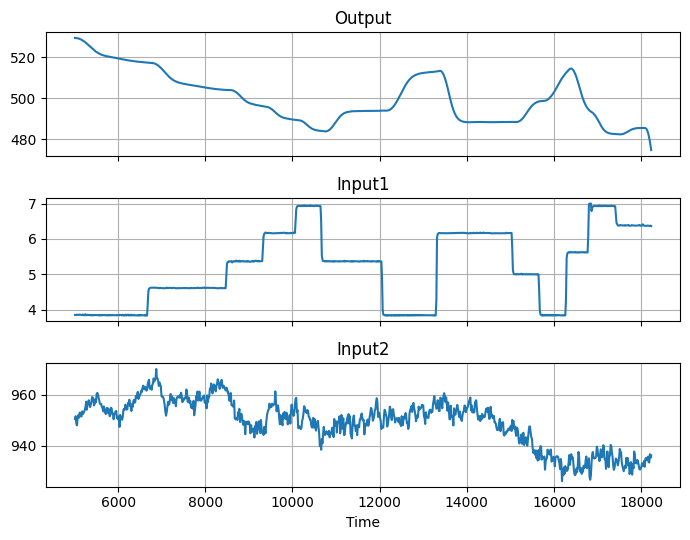

In [28]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 5.5))

data = input_output_data.set_index('Time')

for ax, name in zip(axes, data.columns):
    data[name].plot(ax=ax, grid=True, title=name)

plt.tight_layout()
plt.show()

## Construct Simulation Function

In [29]:
input_col = 'Input1'
t = input_output_data['Time'].to_numpy()
u_data = input_output_data[input_col].to_numpy()
y_data = input_output_data['Output'].to_numpy()

# Determine average time interval
time_step_sizes = np.diff(t)
dt = np.mean(time_step_sizes)
assert np.max(np.abs(time_step_sizes - dt)) < dt / 10
dt

np.float64(15.02181818181818)

In [30]:
# Make simulation function
simulate = make_simulate_function(dt, u_data)

[-11.89612273, 360.83577464, 500.66886236, 534.13787627]

# Test simulate function
K = -10.0
tau = 400.0
n_delay = 2  # must be integer 
y_base = 500.0
u_base = 5.0
y_init = 530.0

y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)
rms_prediction_error(y_model[n_delay+1:], y_data[n_delay+1:])

np.float64(3.429193237223079)

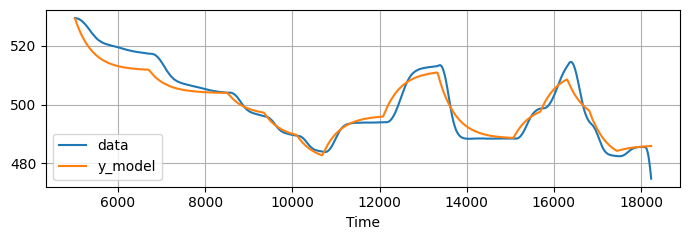

In [31]:
plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
%%timeit

y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

3.28 μs ± 75 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Construct Optimization Problem Class

In [33]:
bounds = calculate_reasonable_bounds(t, u_data, y_data)
var_names = list(bounds.keys())
bounds = list(bounds.values())
bounds

[(np.float64(-86.00479336990831), np.float64(86.00479336990831)),
 (15.08, np.float64(4406.4)),
 (0, 88),
 (np.float64(390.7399912087402), np.float64(609.27040320874)),
 (np.float64(474.7938764), np.float64(584.0590823999999))]

In [35]:
problem = SysIdFOPDT(bounds, dt, u_data, y_data)

# Test cost function evaluation
x = [K, tau, n_delay, y_base, y_init]
rms_error = problem.cost_function_to_minimize(x, u_base=u_base)
rms_error

np.float64(3.4237360514463178)

In [36]:
# Global minimum
K, tau, n_delay, y_base, y_init = [-12.38211837, 416.07825797, 6, 500.71792073, 535.87442099]

x_global_minimum = K, tau, n_delay, y_base, y_init
print(problem.cost_function_to_minimize(x_global_minimum))

2.336465534800444


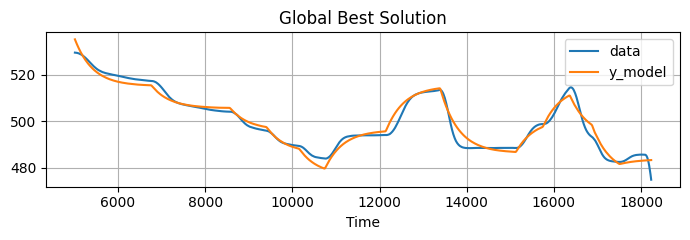

In [37]:
y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.title('Global Best Solution')
plt.tight_layout()
plt.show()

In [38]:
sol = solve_problem_with_optimizer(
    problem, 
    lpfgopt.minimize, 
    problem.bounds,
    discrete=[2],
    points=50,
    tol=0.01,
    maxit=1000,
    seedval=0
)
sol

        best: [np.float64(2.3364655655490436), np.float64(-12.381991294112344), np.float64(416.1045765480444), 6, np.float64(500.71810062158755), np.float64(535.8746939717311)]
 final_error: np.float64(0.009976446745233956)
         fun: np.float64(2.3364655655490436)
       maxcv: 0
     message: 'Tolerance condition satisfied'
        nfev: 850
         nit: 800
    pointset: [[np.float64(2.336465826424156), np.float64(-12.382199628816355), np.float64(416.20309686170384), 6, np.float64(500.7173803371323), np.float64(535.8730079876492)], [np.float64(2.3364656390397562), np.float64(-12.382460640482474), np.float64(416.13788661380806), 6, np.float64(500.717451473042), np.float64(535.8765114206589)], [np.float64(2.336466287354396), np.float64(-12.380214032985895), np.float64(416.0954939299504), 6, np.float64(500.71779107392007), np.float64(535.8691741183871)], [np.float64(2.3364671134646415), np.float64(-12.381468744274843), np.float64(416.1163709173803), 6, np.float64(500.7201849551607)

In [ ]:
# TODO: Convert problem to use scikit-optimize dimensions
dimensions = [
    Real(np.float64(-85.37499999999989), np.float64(85.37499999999989), transform='normalize'),
    Real(np.float64(15.02181818181818), np.float64(4406.4), transform='normalize'),
    Integer(0, 88),  # Integers don't need/support transform parameter
    Real(np.float64(390.72511918274705), np.float64(609.2851191827467), transform='normalize'),
    Real(np.float64(474.79), np.float64(584.0699999999999), transform='normalize')
]
dimensions

Integer(low=0, high=88, prior='uniform', transform='identity')

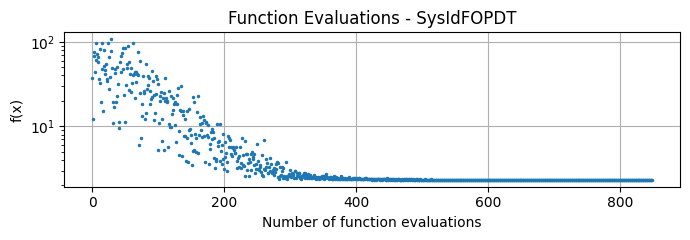

In [40]:
function_evaluations_plot(problem)
plt.tight_layout()
plt.show()

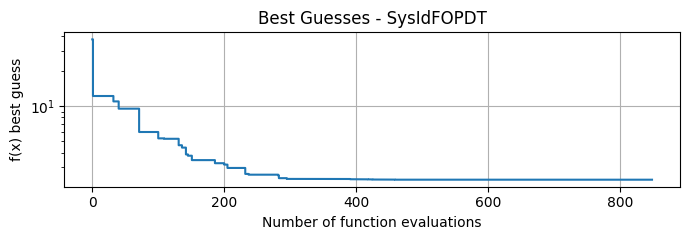

In [41]:
best_guesses_plot(problem)
plt.tight_layout()
plt.show()

### Simulate N Trials - With Integer Delay Variable

In [ ]:
# TODO: Include option to specify initial guess ranges
# Low	High
# [-12	-8]
# [150	200]
# [150	250]
# [470	500]
# [470	490]

100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


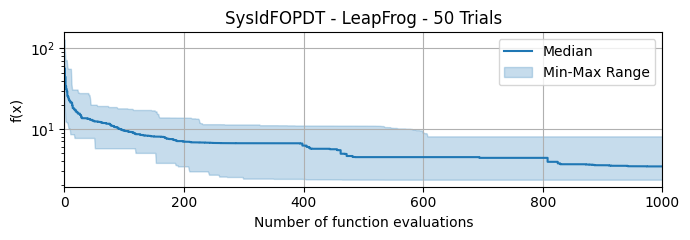

In [ ]:
bounds = [
    (-86.00479336990831, 86.00479336990831),
    (15.08, 4406.4),
    (0, 88),
    (390.7399912087402, 609.27040320874),
    (474.7938764, 584.0590823999999)
]

problem = SysIdFOPDT(bounds, dt, u_data, y_data)

# Test cost function evaluation
x = [K, tau, n_delay, y_base, y_init]
rms_error = problem.cost_function_to_minimize(x, u_base=u_base)
assert np.isclose(rms_error, 2.336465534800444)

n_repeats = 50
maxiter = 1000
method = "LeapFrog"
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem, 
    lpfgopt.minimize, 
    n_repeats, 
    problem.bounds,
    discrete=[2],
    points=50,
    tol=0.01,
    maxit=maxiter,
)
ax = best_guesses_plot_n_repeats(fun_evals, title=f"{problem.name} - {method} - {n_repeats} Trials")
ax.set_xlim([0, maxiter])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"), dpi=150)
plt.show()

In [50]:
best_guess = min(best_guesses)
print(f"f(x): {best_guess[0]}")
print(f"x: {[float(x) for x in best_guess[1]]}")

f(x): 2.336465569124463
x: [-12.382519467132, 416.0954087782719, 6.0, 500.717788091406, 535.8758180404999]


### With Real Delay Variable

100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


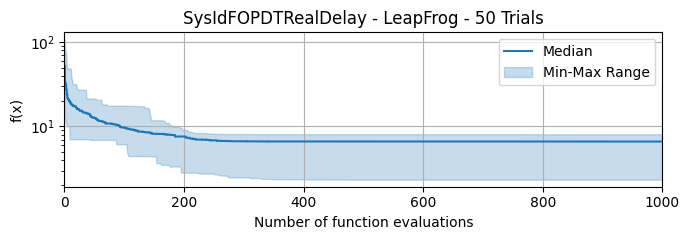

In [63]:
bounds = [
    (-86.00479336990831, 86.00479336990831),
    (15.08, 4406.4),
    (0.0, 1320.0),
    (390.7399912087402, 609.27040320874),
    (474.7938764, 584.0590823999999)
]

problem = SysIdFOPDTRealDelay(bounds, dt, u_data, y_data)

# Test cost function evaluation
x = [K, tau, n_delay * dt, y_base, y_init]
rms_error = problem.cost_function_to_minimize(x, u_base=u_base)
assert np.isclose(rms_error, 2.336465534800444)

n_repeats = 50
maxiter = 1000
method = "LeapFrog"
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem, 
    lpfgopt.minimize, 
    n_repeats, 
    problem.bounds,
    points=50,
    tol=0.01,
    maxit=maxiter,
)
ax = best_guesses_plot_n_repeats(fun_evals, title=f"{problem.name} - {method} - {n_repeats} Trials")
ax.set_xlim([0, maxiter])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"), dpi=150)
plt.show()

In [19]:
x0 = [-12.382173313786181, 416.0781322544548, 6, 500.7178812643235, 535.8717305574411]

f_final = problem(x0)
assert f_final == 2.336465558781636

# Fix n_delay to current value and reduce problem to 5 remaining variables
f5 = lambda x: problem([x[0], x[1], 6, x[2], x[3]])

x0 = [-12.382086606678401, 416.0675766336414, 500.71805709681706, 535.8744229434178]

x0 = [-12.382173313786181, 416.0781322544548, 500.7178812643235, 535.8717305574411]
assert f5(x0) == f_final
f5(x0)

np.float64(2.336465558781636)

In [20]:
# Do additional gradient descent at this point.
res = scipy.optimize.minimize(f5, x0=x0, tol=1e-6)
assert res.status == 0
res.fun, res.x

(np.float64(2.336465534800439),
 array([-12.38211837, 416.07825797, 500.71792073, 535.87442099]))

## Bayesian Optimization

In [21]:
bounds

[(np.float64(-86.00479336990831), np.float64(86.00479336990831)),
 (15.08, np.float64(4406.4)),
 (0, 88),
 (np.float64(390.7399912087402), np.float64(609.27040320874)),
 (np.float64(474.7938764), np.float64(584.0590823999999))]

In [22]:
# Define dimensions - these should be the same as bounds above
dimensions = [
    Real(np.float64(-85.37499999999989), np.float64(85.37499999999989), transform='normalize'),
    Real(np.float64(15.02181818181818), np.float64(4406.4), transform='normalize'),
    Integer(0, 88),  # Integers don't need/support transform parameter
    Real(np.float64(390.72511918274705), np.float64(609.2851191827467), transform='normalize'),
    Real(np.float64(474.79), np.float64(584.0699999999999), transform='normalize')
]

dimensions

[Real(low=-85.37499999999989, high=85.37499999999989, prior='uniform', transform='normalize'),
 Real(low=15.02181818181818, high=4406.4, prior='uniform', transform='normalize'),
 Integer(low=0, high=88, prior='uniform', transform='identity'),
 Real(low=390.72511918274705, high=609.2851191827467, prior='uniform', transform='normalize'),
 Real(low=474.79, high=584.0699999999999, prior='uniform', transform='normalize')]

In [23]:
# Run Bayesian optimization
# 250 Trials takes 15 mins
problem.reset()
res = skopt.gp_minimize(
    problem,
    dimensions,
    n_calls=250,
    noise=1e-10,
    random_state=0,
    n_initial_points=20,
    verbose=True
)
res

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0037
Function value obtained: 68.7976
Current minimum: 68.7976
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0014
Function value obtained: 45.6513
Current minimum: 45.6513
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0021
Function value obtained: 76.3823
Current minimum: 45.6513
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0015
Function value obtained: 66.2811
Current minimum: 45.6513
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0020
Function value obtained: 44.1715
Current minimum: 44.1715
Iteration No: 6 started. 

KeyboardInterrupt: 

In [ ]:
res['x'], res['fun']

In [ ]:
problem.best_guess

In [ ]:
function_evaluations_plot(problem)
plt.tight_layout()
plt.show()

In [ ]:
best_guesses_plot(problem)
plt.tight_layout()
plt.show()

In [ ]:
method = "BayesOpt"
n_repeats = 10
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem,
    skopt.gp_minimize,
    n_repeats,
    dimensions,
    noise=1e-10,
    n_calls=250,
    n_initial_points=20,
)
unique_solutions

In [ ]:
title = f"{problem.name} - {method} - {n_repeats} Trials"
ax = best_guesses_plot_n_repeats(fun_evals, title=title)
plt.tight_layout()
filename = f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"
plt.savefig(os.path.join(plot_dir, filename), dpi=150)
plt.show()

In [ ]:
min(best_guesses)

In [ ]:
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

exp_name = f"{problem.name}_{method}_{n_repeats}"
os.makedirs(os.path.join(results_dir, exp_name), exist_ok=True)

# Save results
np.save(os.path.join(results_dir, exp_name, "fun_evals.npy"), np.stack(fun_evals))
best_guesses_x = np.stack([item[1] for item in best_guesses])
assert best_guesses_x.shape == (n_repeats, 5)
np.save(os.path.join(results_dir, exp_name, "best_guesses_x.npy"), best_guesses_x)
best_guesses_fun = np.stack([item[0] for item in best_guesses])
assert best_guesses_fun.shape == (n_repeats,)
np.save(os.path.join(results_dir, exp_name, "best_guesses_fun.npy"), best_guesses_fun)

## Standard Derivative-Free Optimizers

In [ ]:
bounds = calculate_reasonable_bounds(t, u_data, y_data)
bounds_real_delay = {("theta" if name == "n_delay" else name): b for name, b in bounds.items()}
bounds_real_delay['theta'] = tuple(b * dt for b in bounds_real_delay['theta'])
bounds_real_delay

In [ ]:
K = -12.38205772
tau = 417.6967877
theta = 94.32477261
y_base = 500.7177154
u_base = 5.0
y_init = 535.8743564
dt = 15.08

In [ ]:
problem = SysIdFOPDTRealDelay(bounds_real_delay, dt, u_data, y_data)

# Test cost function evaluation
x = [K, tau, theta, y_base, y_init]
rms_error = problem.cost_function_to_minimize(x, u_base=u_base)
rms_error

In [ ]:
# Generate random start point within the bounds
bounds_array = np.array(list(bounds_real_delay.values()))
x0 = np.random.uniform(bounds_array[:, 0], bounds_array[:, 1], size=bounds_array.shape[0])

sol = solve_problem_with_optimizer(
    problem,
    scipy.optimize.minimize,
    x0,
    method='Powell',
    bounds=list(problem.bounds.values()),
    tol=0.01,
    options={'maxiter': 1000},
)
sol


In [ ]:
function_evaluations_plot(problem)
plt.tight_layout()
plt.show()

In [ ]:
best_guesses_plot(problem)
plt.tight_layout()
plt.show()

In [ ]:
def make_scipy_minimizer_with_random_x0(init_range):
    init_range_array = np.array(init_range)

    def minimizer(fun, **kwargs):
        x0 = np.random.uniform(init_range_array[:, 0], init_range_array[:, 1], size=len(init_range))
        return scipy.optimize.minimize(fun, x0, **kwargs)

    return minimizer


scipy_minimizer = make_scipy_minimizer_with_random_x0(list(problem.bounds.values()))

res = scipy_minimizer(
    problem,
    method='Powell',
    bounds=list(problem.bounds.values()),
    tol=0.01,
    options={'maxiter': 1000}
)
assert res.status == 0
res.fun, res.x

In [ ]:
method = 'Nelder-Mead'
n_repeats = 100
maxiter = 1000
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem,
    scipy_minimizer,
    n_repeats,
    method=method,
    bounds=list(problem.bounds.values()),
    tol=0.01,
    options={'maxiter': 1000}
)
title = f"{problem.name} - {method} - {n_repeats} Trials"
ax = best_guesses_plot_n_repeats(fun_evals, title=title)
ax.set_xlim([0, maxiter])
plt.tight_layout()
filename = f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"
plt.savefig(os.path.join(plot_dir, filename), dpi=150)
plt.show()

In [ ]:
method = 'Powell'
n_repeats = 100
maxiter = 1000
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem,
    scipy_minimizer,
    n_repeats,
    method=method,
    bounds=list(problem.bounds.values()),
    tol=0.01,
    options={'maxiter': maxiter}
)
title=f"{problem.name} - {method} - {n_repeats} Trials"
ax = best_guesses_plot_n_repeats(fun_evals, title=title)
ax.set_xlim([0, maxiter])
plt.tight_layout()
filename = f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"
plt.savefig(os.path.join(plot_dir, filename), dpi=150)
plt.show()

In [ ]:
method = 'LeapFrog'
n_repeats = 100
maxiter = 1000
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem,
    lpfgopt.minimize,
    n_repeats,
    list(problem.bounds.values()),
    points=50,
    tol=0.01,
    maxit=maxiter,
)
title = f"{problem.name} - {method} - {n_repeats} Trials"
ax = best_guesses_plot_n_repeats(fun_evals, title=title)
ax.set_xlim([0, maxiter])
plt.tight_layout()
filename = f"{problem.name}_{method}_convergence_plot_{n_repeats}.png"
plt.savefig(os.path.join(plot_dir, filename), dpi=150)
plt.show()